
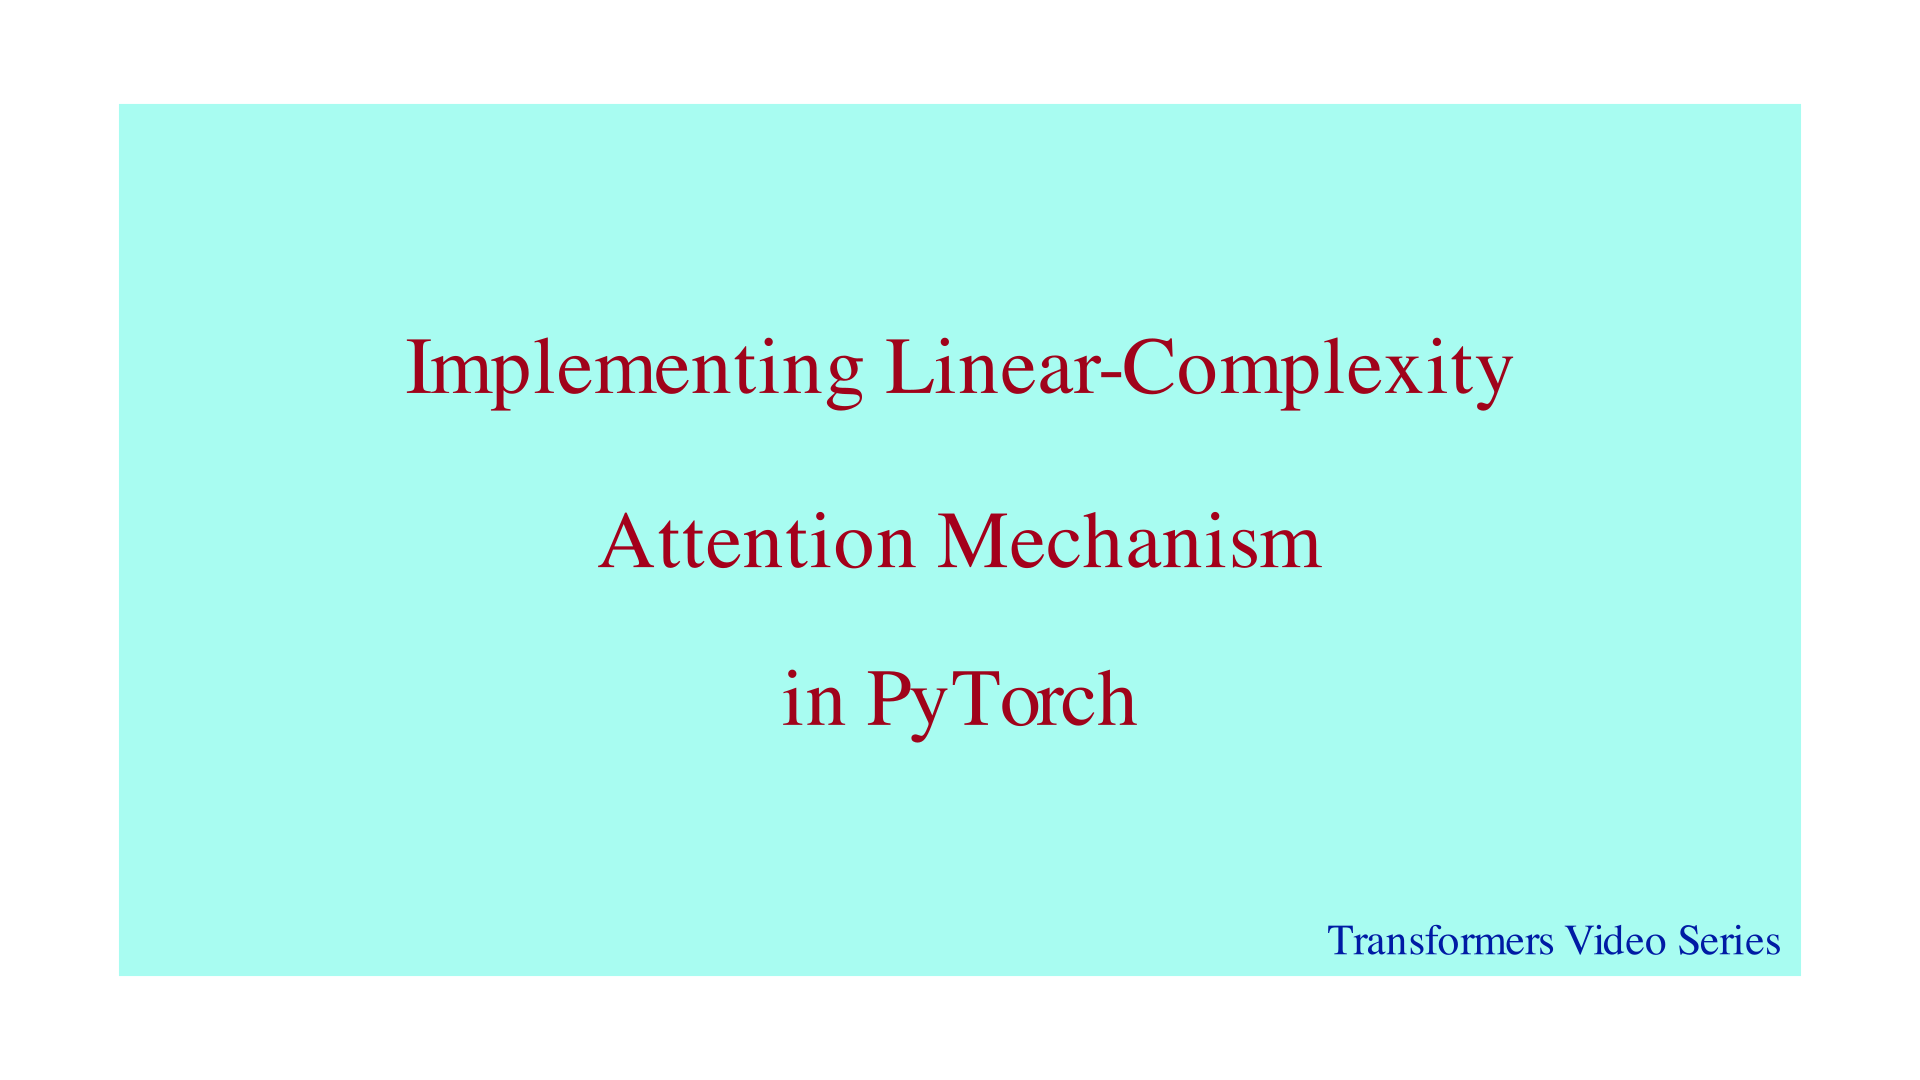

In [1]:
import math
import torch

## Compute Query, Key and Value Matrices


$\text{Input: }\ X\in \mathbb{R}^{N\times d}$

$\text{Projection Matrices:}$  
 * $W_q\in \mathbb{R}^{d\times d_q}$  
 * $W_k\in \mathbb{R}^{d\times d_k}$  
 * $W_v\in \mathbb{R}^{d\times d_v}$
 
Fro simplicity, assume $d_q=d_k=d_v=d$

$\text{Q, K, V Projection:}$

$$Q = XW_q$$
$$K = XW_k$$
$$V = XW_v$$


In [2]:
# define parameters
N = 1000
d = 256  # aka d_model
dk = dq = dv = d  # for simplicity

In [3]:
# Make a random input X
X = torch.rand(N, d)
print('Input X:', X.shape)


# build projection matrices:
Wq = torch.rand(d, dq)
Wk = torch.rand(d, dk)
Wv = torch.rand(d, dv)
print('Wq:', Wq.shape)
print('Wk:', Wk.shape)
print('Wv:', Wv.shape)

Input X: torch.Size([1000, 256])
Wq: torch.Size([256, 256])
Wk: torch.Size([256, 256])
Wv: torch.Size([256, 256])


In [4]:
Q = X.matmul(Wq)
K = X.matmul(Wk)
V = X.matmul(Wv)
print('Q:', Q.shape)
print('K:', K.shape)
print('V:', V.shape)

Q: torch.Size([1000, 256])
K: torch.Size([1000, 256])
V: torch.Size([1000, 256])


## Original Scaled Dot-product Attention $\mathcal{O}(N^2)$

Ref.: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

$$\text{Attention}(Q,K,V)=\text{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V$$



In [6]:
# ~~~~~~~~~~~~~~~ Step 1 ~~~~~~~~~~~~~~~~~~~~
# Compute the attention scores
attention_scores = Q.matmul(K.t())
print('attention_scores:', attention_scores.shape)




# ~~~~~~~~~~~~~~~ Step 2 ~~~~~~~~~~~~~~~~~~~~
# Normalization: applying softmax
attention_weights = torch.softmax(attention_scores / math.sqrt(dk), dim=-1)
print('attention_weights:', attention_weights.shape)

# Sanity-check: each row sums to 1
sum_over_rows = torch.sum(attention_weights, dim=-1)
print('sum_over_rows is all 1?', torch.allclose(sum_over_rows, torch.ones_like(sum_over_rows)))




# ~~~~~~~~~~~~~~~ Step 3 ~~~~~~~~~~~~~~~~~~~~
# Compute the attention output
attention_output = attention_weights.matmul(V)
print('attention_output:', attention_output.shape)

attention_scores: torch.Size([1000, 1000])
attention_weights: torch.Size([1000, 1000])
sum_over_rows is all 1? True
attention_output: torch.Size([1000, 256])


In [8]:
# batched tensors
batch_Q = Q.unsqueeze(0)
batch_K = K.unsqueeze(0)
batch_V = V.unsqueeze(0)
print('batch_Q:', batch_Q.shape)
print('batch_K:', batch_K.shape)
print('batch_V:', batch_V.shape)

# ~~~~~~~~~~~~~~~ Step 1 ~~~~~~~~~~~~~~~~~~~~
# Compute the attention scores
attention_scores = torch.bmm(batch_Q, batch_K.transpose(1, 2))
print('attention_scores:', attention_scores.shape)




# ~~~~~~~~~~~~~~~ Step 2 ~~~~~~~~~~~~~~~~~~~~
# Normalization: applying softmax
attention_weights = torch.softmax(attention_scores / math.sqrt(dk), dim=-1)
print('attention_weights:', attention_weights.shape)

# Sanity-check: each row sums to 1
sum_over_rows = torch.sum(attention_weights, dim=-1)
print('sum_over_rows is all 1?', torch.allclose(sum_over_rows, torch.ones_like(sum_over_rows)))




# ~~~~~~~~~~~~~~~ Step 3 ~~~~~~~~~~~~~~~~~~~~
attention_output = torch.bmm(attention_weights, batch_V)
print('attention_output:', attention_output.shape)

batch_Q: torch.Size([1, 1000, 256])
batch_K: torch.Size([1, 1000, 256])
batch_V: torch.Size([1, 1000, 256])
attention_scores: torch.Size([1, 1000, 1000])
attention_weights: torch.Size([1, 1000, 1000])
sum_over_rows is all 1? True
attention_output: torch.Size([1, 1000, 256])


## Method 1: Efficient-Attention $\mathcal{O}(N)$

Ref.: ["Efficient Attention: Attention with Linear Complexities"](https://arxiv.org/abs/1812.01243)

$$\hat{A}(Q, K, V)=\sigma_\text{row}(Q) \left(\sigma_\text{col} (K)^\top V\right)$$



In [9]:
# ~~~~~~~~~~~~~~~ Step 1 ~~~~~~~~~~~~~~~~~~~~
# Apply sigma to Q and K
sigma_Q = torch.softmax(Q, dim=1)
sigma_K = torch.softmax(K, dim=0)
print('sigma_Q:', sigma_Q.shape)
print('sigma_K:', sigma_K.shape)




# ~~~~~~~~~~~~~~~ Step 2 ~~~~~~~~~~~~~~~~~~~~
# Calculate (sigma_col K)^T x V
step2_result = sigma_K.t().matmul(V)
print('step2_result:', step2_result.shape)




# ~~~~~~~~~~~~~~~ Step 3 ~~~~~~~~~~~~~~~~~~~~
# Calculate the final output
attention_output = sigma_Q.matmul(step2_result)
print('attention_output:', attention_output.shape)

sigma_Q: torch.Size([1000, 256])
sigma_K: torch.Size([1000, 256])
step2_result: torch.Size([256, 256])
attention_output: torch.Size([1000, 256])


## Method 2: Linear Attention using Kernels

Ref.: ["Transformers are RNNs: Fast Autoregressive Transformers with Linear Attention"](https://arxiv.org/abs/2006.16236)

$$\hat{A}(Q,K,V)=\phi(Q)\left(\phi(K)^\top V\right)$$

$\text{where feature function }\ \phi(x) = ELU(x) + 1$

<img src="elu.png" alt="ELU(x)" style="width:250px;"/>


In [10]:
elu = torch.nn.ELU()
def phi(x):
    return elu(x) + 1


# ~~~~~~~~~~~~~~~ Step 1 ~~~~~~~~~~~~~~~~~~~~
# Apply phi to Q and K
phi_Q = phi(Q)
phi_K = phi(K)


# ~~~~~~~~~~~~~~~ Step 2 ~~~~~~~~~~~~~~~~~~~~
# Calculate (phi_K)^T x V
step2_result = phi_K.t().matmul(V)
print('step2_result:', step2_result.shape)


# ~~~~~~~~~~~~~~~ Step 3 ~~~~~~~~~~~~~~~~~~~~
#  final output
attention_output = phi_Q.matmul(step2_result)
print('attention_output:', attention_output.shape)

step2_result: torch.Size([256, 256])
attention_output: torch.Size([1000, 256])


## Method 3: Linear Attention using Taylor Series Approximation $\mathcal{O}(N)$

Ref.: ["Linear Attention Mechanism: An Efficient Attention for Semantic Segmentation"](https://arxiv.org/abs/2007.14902)

$$\hat{A}(Q,K,V)=\frac{V^\top.\mathbb{1}_N + Q^\prime \left({K^\prime}^\top V\right)}{N+Q^\prime \left({K^\prime}^\top .\mathbb{1}_N\right)}$$

$\text{where }\ $  
* $Q^\prime = \frac{Q}{\|Q\|_2}$  
* $K^\prime = \frac{K}{\|K\|_2}$

In [11]:
# Create a vector of ones
one_N = torch.ones(N)
print('one_N:', one_N.shape)

one_N: torch.Size([1000])


In [13]:
# ~~~~~~~~~~~~~~~ Step 1 ~~~~~~~~~~~~~~~~~~~~
# Normalize Q and K
norm_of_Q = torch.norm(Q, p=2, dim=1, keepdim=True)
norm_of_K = torch.norm(K, p=2, dim=1, keepdim=True)
print('norm_of_Q:', norm_of_Q.shape)
print('norm_of_K:', norm_of_K.shape)
Q_prime = Q / norm_of_Q
K_prime = K / norm_of_K



# ~~~~~~~~~~~~~~~ Step 2 ~~~~~~~~~~~~~~~~~~~~
# Calculate intermediate terms
term1 = V.t().matmul(one_N)
term2 = Q_prime.matmul(K_prime.t().matmul(V))
term3 = Q_prime.matmul(K_prime.t().matmul(one_N))
print('term1:', term1.shape)
print('term2:', term2.shape)
print('term3:', term3.shape)


# ~~~~~~~~~~~~~~~ Step 3 ~~~~~~~~~~~~~~~~~~~~
# Compute the final result
attention_output = (term1 + term2) / (N + term3.unsqueeze(-1))
print('attention_output:', attention_output.shape)

norm_of_Q: torch.Size([1000, 1])
norm_of_K: torch.Size([1000, 1])
term1: torch.Size([256])
term2: torch.Size([1000, 256])
term3: torch.Size([1000])
attention_output: torch.Size([1000, 256])


## Method 4: Linformer's Attention $\mathcal{O}(N)$

Ref.: ["Linformer: Self-Attention with Linear Complexity"](https://arxiv.org/abs/2006.04768)

$\text{Low-rank approximation: projection matrices }E,F\in \mathbb{R}^{r\times N}$

$\longrightarrow EK \in \mathbb{R}^{r\times d_k}$  
$\longrightarrow FV \in \mathbb{R}^{r\times d_v}$

$\text{Context-mapping matrix P: }\ \ P=\text{Softmax}\left(\frac{Q(EK)^\top}{\sqrt{d_k}}\right)$


$$\hat{A}(Q,EK,EV)=\text{Softmax}\left(\frac{Q(EK)^\top}{\sqrt{d_k}}\right)FV$$

In [14]:
# assume r is 100
r = 100

# Define random projection matrices E and F
E = torch.rand(r, N)
F = torch.rand(r, N)

In [15]:
# ~~~~~~~~~~~~~~~ Step 1 ~~~~~~~~~~~~~~~~~~~~
# Project K and V
EK = E.matmul(K)
FV = F.matmul(V)
print('EK:', EK.shape)
print('FV:', FV.shape)




# ~~~~~~~~~~~~~~~ Step 2 ~~~~~~~~~~~~~~~~~~~~
# Compute the context-mapping matrix P
P = torch.softmax(Q.matmul(EK.t()) / math.sqrt(dk), dim=1)
print('Context-mapping matrix P:', P.shape)




# ~~~~~~~~~~~~~~~ Step 3 ~~~~~~~~~~~~~~~~~~~~
# Compute the final output
attention_output = P.matmul(FV)
print('attention_output:', attention_output.shape)

EK: torch.Size([100, 256])
FV: torch.Size([100, 256])
Context-mapping matrix P: torch.Size([1000, 100])
attention_output: torch.Size([1000, 256])
